# Spam Message Classifier using RoBERTa

## Introduction

Spam messages are a widespread issue across digital communication platforms, disrupting user experience and trust. This project focuses on building a **spam message classifier** using **RoBERTa**, a state-of-the-art transformer model for natural language understanding.

We use the **SMS Spam Collection Dataset** to fine-tune RoBERTa for binary spam classification. This provides a strong and generalized spam detection model suitable for various text-based environments.

---

## Objectives

- Preprocess and clean SMS messages
- Fine-tune a pre-trained RoBERTa model
- Evaluate model performance using precision, recall, and F1-score
- Save and prepare the trained model for future integration

---

## Dataset: SMS Spam Collection

We utilize the [SMS Spam Collection Dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset) published by UCI, which includes:

- `v1`: Label (`ham` or `spam`)
- `v2`: SMS message text

### Preprocessing Steps

- Rename columns for clarity
- Convert labels to binary:
  - `ham` → `0` (not spam)
  - `spam` → `1` (spam)
- Tokenize and encode messages for transformer input

---

## Model: RoBERTa

We fine-tune a pre-trained `roberta-base` model using Hugging Face Transformers. The model is trained on the processed SMS dataset with a binary classification head.

---

## Evaluation Metrics

We evaluate the model using standard classification metrics:

- **Precision**
- **Recall**
- **F1-score**
- **Accuracy**

### Acceptance Criteria

To ensure the model's reliability in real-world deployment, we define the following criterion:

> **The model will be considered acceptable if the F1-score for the `spam` class exceeds 0.95 on the test dataset.**

This threshold ensures the classifier effectively balances **precision** and **recall** for detecting spam, minimizing both false positives and false negatives.

---

## Output

The trained model, tokenizer, and preprocessing pipeline are saved in Hugging Face format, ready for inference or deployment.

You can find the trained model here:  
👉 **[roshana1s/spam-message-classifier on Hugging Face](https://huggingface.co/roshana1s/spam-message-classifier)**

---

## Integration with Amy (Discord Bot)

This spam classifier will be integrated into **Amy** — an intelligent Discord bot capable of:

- Detecting spam messages in real-time using this RoBERTa-based model
- Identifying toxic or harmful messages (via a **separate toxicity detection model**)

This project serves as the core backend for Amy’s moderation capabilities in Discord servers.

---

## Preparing the tools

In [2]:
# General libraries
import pandas as pd
import numpy as np
import random

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - preprocessing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

# Hugging Face Transformers
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding

# Dataset
from datasets import Dataset

# PyTorch (used under the hood by transformers)
import torch
from torch import nn

# Optuna for hyperparameter tuning
import optuna

import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath('..'))

2025-07-27 09:38:25.661293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753609106.021389      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753609106.126316      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import re

def preprocess_text(text: str) -> str:
    text = re.sub(r"(https?:\/\/)?(www\.)?(discord\.(gg|io|me|li)|discordapp\.com\/invite)\/\S+", "<DISCORD_INVITE>", text)  # Discord invites first
    text = re.sub(r"(https?://\S+|www\.\S+)", "<URL>", text)  # URLs
    text = re.sub(r"<@!?\d+>", "<USER>", text)                # Mentions
    text = re.sub(r"<a?:\w+:\d+>", "<EMOJI>", text)           # Emojis
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

## Load Data

In [4]:
df = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding="latin1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df = df[['v1', 'v2']]  # Keep only label and message
df.columns = ['label', 'text']  # Rename for consistency
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# Convert labels to numbers
# Convert spam/ham to 1/0
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df["label"].value_counts()

label
0    4825
1     747
Name: count, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   int64 
 1   text    5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [9]:
df.isna().sum()

label    0
text     0
dtype: int64

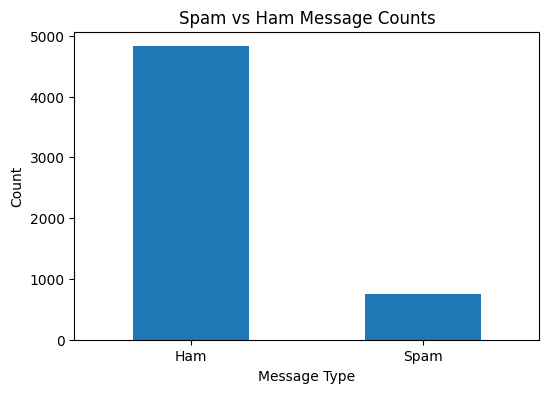

In [10]:
df["label"].value_counts().plot(kind='bar', figsize=(6,4))
plt.title("Spam vs Ham Message Counts")
plt.xlabel("Message Type")
plt.ylabel("Count")
plt.xticks(ticks=[0,1], labels=['Ham', 'Spam'], rotation=0)
plt.show()

We can clearly see, there is class imbalance between `spam` and `ham`.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

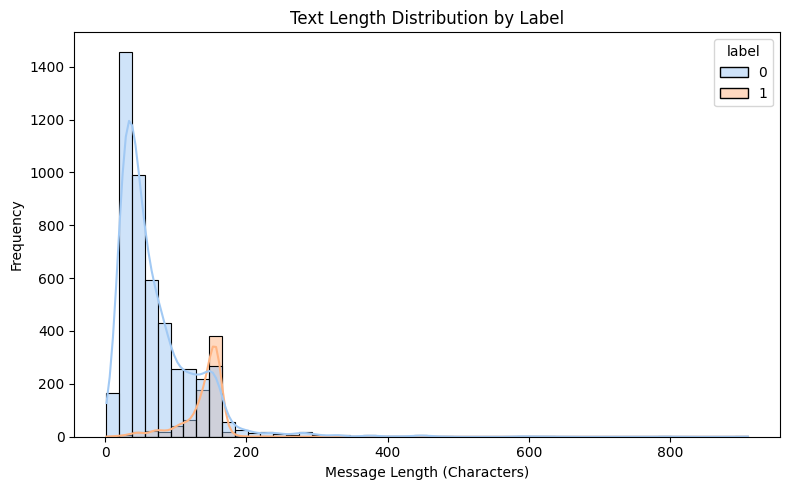

In [11]:
df["len"] = df["text"].apply(len)

# Plot text length distribution
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="len", hue='label', bins=50, kde=True, palette='pastel')
plt.title("Text Length Distribution by Label")
plt.xlabel("Message Length (Characters)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show();

## Clean Data

In [12]:
df["cleaned_text"] = df["text"].apply(preprocess_text)

In [13]:
df

,label,text,len,cleaned_text
0,0,"Go until jurong point, crazy.. Available only ...",111,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...,29,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...,49,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro...",61,"Nah I don't think he goes to usf, he lives aro..."
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?,37,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s...",57,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...,125,The guy did some bitching but I acted like i'd...


## Split Data

In [14]:
# Split data - preserve class distribution
train_df, temp_df = train_test_split(
    df, 
    test_size=0.3, 
    random_state=42,
    stratify=df['label']  # Maintain class balance in splits
)
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    random_state=42,
    stratify=temp_df['label']
)

In [15]:
train_df.shape, val_df.shape, test_df.shape

((3900, 4), (836, 4), (836, 4))

In [16]:
train_df["label"].value_counts()

label
0    3377
1     523
Name: count, dtype: int64

In [17]:
val_df["label"].value_counts()

label
0    724
1    112
Name: count, dtype: int64

In [18]:
test_df["label"].value_counts()

label
0    724
1    112
Name: count, dtype: int64

In [19]:
train_df

,label,text,len,cleaned_text
4912,1,"Goal! Arsenal 4 (Henry, 7 v Liverpool 2 Henry ...",155,"Goal! Arsenal 4 (Henry, 7 v Liverpool 2 Henry ..."
2541,0,I dont. Can you send it to me. Plus how's mode.,47,I dont. Can you send it to me. Plus how's mode.
5323,0,Aah bless! How's your arm?,26,Aah bless! How's your arm?
5171,0,Oh k. . I will come tomorrow,28,Oh k. . I will come tomorrow
2532,0,Yup ok...,9,Yup ok...
...,...,...,...,...
3185,0,Happy birthday to you....dear.with lots of lov...,59,Happy birthday to you....dear.with lots of lov...
607,0,what I meant to say is cant wait to see u agai...,87,what I meant to say is cant wait to see u agai...
552,0,"Sure, if I get an acknowledgement from you tha...",120,"Sure, if I get an acknowledgement from you tha..."
763,0,Nothing but we jus tot u would ask cos u ba gu...,151,Nothing but we jus tot u would ask cos u ba gu...


We know that in this dataset, class imbalance is high. So, we need to have weighted trainer for that.

## Compute Class Weights

Let's compute class weights, then we can have a weighted loss function with computed class weights.

In [20]:
# Calculate weights based on TRAINING SET only
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

print(f"Class weights: {class_weights}")
# Example output: [0.588, 3.333] for 85/15 split

# Convert to PyTorch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float)

Class weights: [0.57743559 3.72848948]


## Tokenization

In [21]:
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [22]:
# Analyze optimal sequence length
token_lengths = train_df['cleaned_text'].apply(lambda x: len(tokenizer.tokenize(x)))
optimal_max_len = int(np.percentile(token_lengths, 95)) + 5  # 95th percentile + buffer

In [23]:
optimal_max_len

57

In [24]:
def tokenize_function(batch):
    try:
        return tokenizer(
            batch['text'],
            truncation=True,
            max_length=min(optimal_max_len, 512),
            padding=False,
            return_attention_mask=True,
            return_tensors=None
        )
    except Exception as e:
        print(f"Tokenization error: {e}")
        raise

In [25]:
# 1. Select only necessary columns
train_df = train_df[['label', 'cleaned_text']].rename(columns={'cleaned_text': 'text'})
val_df = val_df[['label', 'cleaned_text']].rename(columns={'cleaned_text': 'text'})
test_df = test_df[['label', 'cleaned_text']].rename(columns={'cleaned_text': 'text'})

# 2. Convert to Dataset objects (with proper validation)
train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
val_dataset = Dataset.from_pandas(val_df, preserve_index=False)
test_dataset = Dataset.from_pandas(test_df, preserve_index=False)

In [26]:
# 3. Apply tokenization
tokenized_train = train_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=1000,
    remove_columns=['text']  # Remove original text after tokenization
)

tokenized_val = val_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=1000,
    remove_columns=['text']
)

tokenized_test = test_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=1000,
    remove_columns=['text']
)

# 5. Sort only training set by length
tokenized_train = tokenized_train.add_column(
    "length",
    [len(x) for x in tokenized_train["input_ids"]]
).sort("length")

# Final datasets
train_dataset = tokenized_train
val_dataset = tokenized_val
test_dataset = tokenized_test

Map:   0%|          | 0/3900 [00:00<?, ? examples/s]

Map:   0%|          | 0/836 [00:00<?, ? examples/s]

Map:   0%|          | 0/836 [00:00<?, ? examples/s]

In [27]:
tokenized_train

Dataset({
    features: ['label', 'input_ids', 'attention_mask', 'length'],
    num_rows: 3900
})

In [28]:
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding='longest',  # Pad to longest in batch
    max_length=optimal_max_len,  # Safety cap
    return_tensors="pt"
)

## Custom Trainer to use a weighted loss

In [29]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(kwargs['args'].device)
        
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

## Compute metrics function

In [30]:
def compute_metrics(eval_pred):
    """Robust metrics for imbalanced binary classification"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Essential metrics (all weighted by class support)
    metrics = {
        'accuracy': accuracy_score(labels, predictions),
        'f1_weighted': f1_score(labels, predictions, average='weighted'),
        'precision_weighted': precision_score(labels, predictions, average='weighted'),
        'recall_weighted': recall_score(labels, predictions, average='weighted'),
    }
    
    # Class-specific metrics
    metrics.update({
        # Spam class (label=1)
        'spam_precision': precision_score(labels, predictions, pos_label=1),
        'spam_recall': recall_score(labels, predictions, pos_label=1),
        'spam_f1': f1_score(labels, predictions, pos_label=1),
        
        # Ham class (label=0)
        'ham_precision': precision_score(labels, predictions, pos_label=0),
        'ham_recall': recall_score(labels, predictions, pos_label=0),
    })
    
    # Confusion matrix breakdown
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    metrics.update({
        'confusion_matrix': {
            'true_negatives': int(tn),  # Correct hams
            'false_positives': int(fp), # Hams misclassified as spam (bad)
            'false_negatives': int(fn), # Spam missed (very bad)
            'true_positives': int(tp),  # Correct spam
        },
        'false_positive_rate': fp / (fp + tn),  # % of hams flagged as spam
        'false_negative_rate': fn / (fn + tp),  # % of spam missed
    })
    
    return metrics

## Optuna for Hyperparameter Tuning

In [31]:
# Define objective function
def objective(trial):
    # 1. Get parameters
    model_params = {
        "hidden_dropout_prob": trial.suggest_float("hidden_dropout", 0.2, 0.4),
        "attention_probs_dropout_prob": trial.suggest_float("attn_dropout", 0.1, 0.2)
    }

    training_params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 3e-5),
        "weight_decay": trial.suggest_float("weight_decay", 0.01, 0.1),
        "per_device_train_batch_size": trial.suggest_categorical("batch_size", [16, 32]),
        "gradient_accumulation_steps": trial.suggest_int("grad_accum", 1, 2),
        "num_train_epochs": trial.suggest_int("epochs", 3, 8),
        "warmup_ratio": trial.suggest_float("warmup", 0.05, 0.15)
    }
    
    # 2. Define the model
    model = RobertaForSequenceClassification.from_pretrained(
        'FacebookAI/roberta-base',
        num_labels=2,
        id2label={0: "ham", 1: "spam"},
        **model_params,
    )
    
    # 3. Create training arguments
    training_args = TrainingArguments(
        output_dir=f'/kaggle/temp',
        eval_strategy="steps",
        eval_steps=200,
        save_strategy="steps",
        save_steps=200,
        metric_for_best_model="eval_spam_f1",
        greater_is_better=True,
        load_best_model_at_end=True,
        fp16=True,
        per_device_eval_batch_size=64,
        report_to="none",
        **training_params,
    )
    
    # 4. Train with class weights
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        class_weights=class_weights
    )
    
    trainer.train()
    results = trainer.evaluate()
    return results['eval_spam_f1']

In [32]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

best_params = study.best_params

[I 2025-07-27 09:38:53,914] A new study created in memory with name: no-name-0e5689c8-6baa-41c6-8dc2-2211ba800935


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
200,No log,0.097471,0.989234,0.989333,0.989576,0.989234,0.940171,0.982143,0.960699,0.997218,0.990331,"{'true_negatives': 717, 'false_positives': 7, 'false_negatives': 2, 'true_positives': 110}",0.009669,0.017857


[I 2025-07-27 09:42:28,819] Trial 0 finished with value: 0.9606986899563319 and parameters: {'hidden_dropout': 0.27157355843026443, 'attn_dropout': 0.14573345731035747, 'learning_rate': 2.0700368821077562e-05, 'weight_decay': 0.05407827645438941, 'batch_size': 32, 'grad_accum': 2, 'epochs': 8, 'warmup': 0.11852600183901789}. Best is trial 0 with value: 0.9606986899563319.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


[I 2025-07-27 09:45:07,832] Trial 1 finished with value: 0.9694323144104804 and parameters: {'hidden_dropout': 0.29102820143553876, 'attn_dropout': 0.195954092898259, 'learning_rate': 1.9825737288521536e-05, 'weight_decay': 0.0788443459563087, 'batch_size': 32, 'grad_accum': 2, 'epochs': 6, 'warmup': 0.13600208378688539}. Best is trial 1 with value: 0.9694323144104804.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
200,No log,0.100114,0.986842,0.986867,0.986897,0.986842,0.946903,0.955357,0.951111,0.993084,0.991713,"{'true_negatives': 718, 'false_positives': 6, 'false_negatives': 5, 'true_positives': 107}",0.008287,0.044643


[I 2025-07-27 09:48:06,370] Trial 2 finished with value: 0.9511111111111111 and parameters: {'hidden_dropout': 0.36188868199229507, 'attn_dropout': 0.1976141383115735, 'learning_rate': 1.1116860632197424e-05, 'weight_decay': 0.08607089685940436, 'batch_size': 16, 'grad_accum': 2, 'epochs': 5, 'warmup': 0.14268711639828333}. Best is trial 1 with value: 0.9694323144104804.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
200,No log,0.146605,0.986842,0.986817,0.986798,0.986842,0.954955,0.946429,0.950673,0.991724,0.993094,"{'true_negatives': 719, 'false_positives': 5, 'false_negatives': 6, 'true_positives': 106}",0.006906,0.053571
400,No log,0.195251,0.990431,0.990466,0.990526,0.990431,0.956140,0.973214,0.964602,0.995845,0.993094,"{'true_negatives': 719, 'false_positives': 5, 'false_negatives': 3, 'true_positives': 109}",0.006906,0.026786
600,0.350000,0.193305,0.992823,0.992850,0.992900,0.992823,0.964912,0.982143,0.973451,0.997230,0.994475,"{'true_negatives': 720, 'false_positives': 4, 'false_negatives': 2, 'true_positives': 110}",0.005525,0.017857
800,0.350000,0.205745,0.991627,0.991673,0.991773,0.991627,0.956522,0.982143,0.969163,0.997226,0.993094,"{'true_negatives': 719, 'false_positives': 5, 'false_negatives': 2, 'true_positives': 110}",0.006906,0.017857


[I 2025-07-27 09:52:42,839] Trial 3 finished with value: 0.9734513274336283 and parameters: {'hidden_dropout': 0.3446092654003281, 'attn_dropout': 0.13037412033915508, 'learning_rate': 1.1810788733172074e-05, 'weight_decay': 0.05405341850352894, 'batch_size': 16, 'grad_accum': 1, 'epochs': 7, 'warmup': 0.1320056870782835}. Best is trial 3 with value: 0.9734513274336283.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
200,No log,0.133357,0.982057,0.982468,0.983777,0.982057,0.888000,0.991071,0.936709,0.998594,0.980663,"{'true_negatives': 710, 'false_positives': 14, 'false_negatives': 1, 'true_positives': 111}",0.019337,0.008929
400,No log,0.098829,0.994019,0.994052,0.994139,0.994019,0.965217,0.991071,0.977974,0.998613,0.994475,"{'true_negatives': 720, 'false_positives': 4, 'false_negatives': 1, 'true_positives': 111}",0.005525,0.008929


[I 2025-07-27 09:56:36,678] Trial 4 finished with value: 0.9779735682819383 and parameters: {'hidden_dropout': 0.24535892153124866, 'attn_dropout': 0.1917522757023868, 'learning_rate': 2.9947215613546497e-05, 'weight_decay': 0.0945138876333508, 'batch_size': 32, 'grad_accum': 1, 'epochs': 8, 'warmup': 0.08223555323886156}. Best is trial 4 with value: 0.9779735682819383.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
200,No log,0.144591,0.982057,0.982348,0.983080,0.982057,0.900826,0.973214,0.935622,0.995804,0.983425,"{'true_negatives': 712, 'false_positives': 12, 'false_negatives': 3, 'true_positives': 109}",0.016575,0.026786
400,No log,0.165620,0.988038,0.988169,0.988505,0.988038,0.932203,0.982143,0.956522,0.997214,0.988950,"{'true_negatives': 716, 'false_positives': 8, 'false_negatives': 2, 'true_positives': 110}",0.011050,0.017857


[I 2025-07-27 10:00:03,286] Trial 5 finished with value: 0.9565217391304348 and parameters: {'hidden_dropout': 0.3592862705995072, 'attn_dropout': 0.15650845960813342, 'learning_rate': 1.8108845406913755e-05, 'weight_decay': 0.07128254866925145, 'batch_size': 32, 'grad_accum': 1, 'epochs': 7, 'warmup': 0.1287886724429373}. Best is trial 4 with value: 0.9779735682819383.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
200,No log,0.280400,0.988038,0.987993,0.987971,0.988038,0.963636,0.946429,0.954955,0.991736,0.994475,"{'true_negatives': 720, 'false_positives': 4, 'false_negatives': 6, 'true_positives': 106}",0.005525,0.053571
400,No log,0.167168,0.989234,0.989371,0.989786,0.989234,0.932773,0.991071,0.961039,0.998605,0.988950,"{'true_negatives': 716, 'false_positives': 8, 'false_negatives': 1, 'true_positives': 111}",0.011050,0.008929
600,0.397000,0.115737,0.994019,0.994052,0.994139,0.994019,0.965217,0.991071,0.977974,0.998613,0.994475,"{'true_negatives': 720, 'false_positives': 4, 'false_negatives': 1, 'true_positives': 111}",0.005525,0.008929
800,0.397000,0.129263,0.992823,0.992876,0.993023,0.992823,0.956897,0.991071,0.973684,0.998611,0.993094,"{'true_negatives': 719, 'false_positives': 5, 'false_negatives': 1, 'true_positives': 111}",0.006906,0.008929


[I 2025-07-27 10:04:46,795] Trial 6 finished with value: 0.9779735682819383 and parameters: {'hidden_dropout': 0.33630632133319716, 'attn_dropout': 0.15104578160814475, 'learning_rate': 2.6388129012401625e-05, 'weight_decay': 0.08376764568656594, 'batch_size': 16, 'grad_accum': 1, 'epochs': 7, 'warmup': 0.1400584945465813}. Best is trial 4 with value: 0.9779735682819383.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


[I 2025-07-27 10:07:00,229] Trial 7 finished with value: 0.9606986899563319 and parameters: {'hidden_dropout': 0.3121226503940271, 'attn_dropout': 0.15872036750582208, 'learning_rate': 2.0281968064594603e-05, 'weight_decay': 0.0416731456055434, 'batch_size': 32, 'grad_accum': 2, 'epochs': 5, 'warmup': 0.09886023338964593}. Best is trial 4 with value: 0.9779735682819383.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
200,No log,0.293065,0.989234,0.989214,0.989200,0.989234,0.963964,0.955357,0.959641,0.993103,0.994475,"{'true_negatives': 720, 'false_positives': 4, 'false_negatives': 5, 'true_positives': 107}",0.005525,0.044643
400,No log,0.239198,0.979665,0.980197,0.981900,0.979665,0.874016,0.991071,0.928870,0.998590,0.977901,"{'true_negatives': 708, 'false_positives': 16, 'false_negatives': 1, 'true_positives': 111}",0.022099,0.008929
600,0.381600,0.114231,0.995215,0.995233,0.995275,0.995215,0.973684,0.991071,0.982301,0.998615,0.995856,"{'true_negatives': 721, 'false_positives': 3, 'false_negatives': 1, 'true_positives': 111}",0.004144,0.008929


[I 2025-07-27 10:11:00,727] Trial 8 finished with value: 0.9823008849557523 and parameters: {'hidden_dropout': 0.3520095321182608, 'attn_dropout': 0.10661882421941633, 'learning_rate': 2.200538015747215e-05, 'weight_decay': 0.07565561130957736, 'batch_size': 16, 'grad_accum': 1, 'epochs': 6, 'warmup': 0.05202632223716014}. Best is trial 8 with value: 0.9823008849557523.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
200,No log,0.195129,0.990431,0.990431,0.990431,0.990431,0.964286,0.964286,0.964286,0.994475,0.994475,"{'true_negatives': 720, 'false_positives': 4, 'false_negatives': 4, 'true_positives': 108}",0.005525,0.035714
400,No log,0.183972,0.994019,0.994030,0.994048,0.994019,0.973451,0.982143,0.977778,0.997234,0.995856,"{'true_negatives': 721, 'false_positives': 3, 'false_negatives': 2, 'true_positives': 110}",0.004144,0.017857
600,0.326100,0.101038,0.995215,0.995233,0.995275,0.995215,0.973684,0.991071,0.982301,0.998615,0.995856,"{'true_negatives': 721, 'false_positives': 3, 'false_negatives': 1, 'true_positives': 111}",0.004144,0.008929
800,0.326100,0.085657,0.995215,0.995233,0.995275,0.995215,0.973684,0.991071,0.982301,0.998615,0.995856,"{'true_negatives': 721, 'false_positives': 3, 'false_negatives': 1, 'true_positives': 111}",0.004144,0.008929


[I 2025-07-27 10:16:18,731] Trial 9 finished with value: 0.9823008849557523 and parameters: {'hidden_dropout': 0.28474996922876944, 'attn_dropout': 0.11558320650216156, 'learning_rate': 1.6725363743262388e-05, 'weight_decay': 0.06521208341105217, 'batch_size': 16, 'grad_accum': 1, 'epochs': 8, 'warmup': 0.11664364858508561}. Best is trial 8 with value: 0.9823008849557523.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
200,No log,0.296965,0.986842,0.986867,0.986897,0.986842,0.946903,0.955357,0.951111,0.993084,0.991713,"{'true_negatives': 718, 'false_positives': 6, 'false_negatives': 5, 'true_positives': 107}",0.008287,0.044643


[I 2025-07-27 10:18:17,987] Trial 10 finished with value: 0.9511111111111111 and parameters: {'hidden_dropout': 0.39767315251127394, 'attn_dropout': 0.1013243976797314, 'learning_rate': 2.4998709866388944e-05, 'weight_decay': 0.033147218500017436, 'batch_size': 16, 'grad_accum': 1, 'epochs': 3, 'warmup': 0.05549358435884668}. Best is trial 8 with value: 0.9823008849557523.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
200,No log,0.126972,0.990431,0.990536,0.990846,0.990431,0.940678,0.991071,0.965217,0.998607,0.990331,"{'true_negatives': 717, 'false_positives': 7, 'false_negatives': 1, 'true_positives': 111}",0.009669,0.008929


[I 2025-07-27 10:20:19,157] Trial 11 finished with value: 0.9652173913043479 and parameters: {'hidden_dropout': 0.2281153319109438, 'attn_dropout': 0.10095148264405933, 'learning_rate': 1.56541883654463e-05, 'weight_decay': 0.01724922859987496, 'batch_size': 16, 'grad_accum': 1, 'epochs': 3, 'warmup': 0.0523067037925652}. Best is trial 8 with value: 0.9823008849557523.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
200,No log,0.115896,0.990431,0.990536,0.990846,0.990431,0.940678,0.991071,0.965217,0.998607,0.990331,"{'true_negatives': 717, 'false_positives': 7, 'false_negatives': 1, 'true_positives': 111}",0.009669,0.008929
400,No log,0.202218,0.991627,0.991673,0.991773,0.991627,0.956522,0.982143,0.969163,0.997226,0.993094,"{'true_negatives': 719, 'false_positives': 5, 'false_negatives': 2, 'true_positives': 110}",0.006906,0.017857
600,0.270700,0.144489,0.990431,0.990536,0.990846,0.990431,0.940678,0.991071,0.965217,0.998607,0.990331,"{'true_negatives': 717, 'false_positives': 7, 'false_negatives': 1, 'true_positives': 111}",0.009669,0.008929


[I 2025-07-27 10:24:20,658] Trial 12 finished with value: 0.9691629955947136 and parameters: {'hidden_dropout': 0.26833113745663717, 'attn_dropout': 0.11929848881255058, 'learning_rate': 1.5666032554379137e-05, 'weight_decay': 0.06847286633386497, 'batch_size': 16, 'grad_accum': 1, 'epochs': 6, 'warmup': 0.0753059125496}. Best is trial 8 with value: 0.9823008849557523.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
200,No log,0.194370,0.991627,0.991673,0.991773,0.991627,0.956522,0.982143,0.969163,0.997226,0.993094,"{'true_negatives': 719, 'false_positives': 5, 'false_negatives': 2, 'true_positives': 110}",0.006906,0.017857
400,No log,0.108609,0.994019,0.994052,0.994139,0.994019,0.965217,0.991071,0.977974,0.998613,0.994475,"{'true_negatives': 720, 'false_positives': 4, 'false_negatives': 1, 'true_positives': 111}",0.005525,0.008929
600,0.295400,0.140799,0.994019,0.994030,0.994048,0.994019,0.973451,0.982143,0.977778,0.997234,0.995856,"{'true_negatives': 721, 'false_positives': 3, 'false_negatives': 2, 'true_positives': 110}",0.004144,0.017857
800,0.295400,0.164862,0.996411,0.996405,0.996404,0.996411,0.990991,0.982143,0.986547,0.997241,0.998619,"{'true_negatives': 723, 'false_positives': 1, 'false_negatives': 2, 'true_positives': 110}",0.001381,0.017857


[I 2025-07-27 10:29:39,312] Trial 13 finished with value: 0.9865470852017937 and parameters: {'hidden_dropout': 0.20291736458414722, 'attn_dropout': 0.11848231738315876, 'learning_rate': 2.3801104478354158e-05, 'weight_decay': 0.06251038184274911, 'batch_size': 16, 'grad_accum': 1, 'epochs': 8, 'warmup': 0.10760084868802057}. Best is trial 13 with value: 0.9865470852017937.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
200,No log,0.227545,0.991627,0.991643,0.991664,0.991627,0.964602,0.973214,0.968889,0.995851,0.994475,"{'true_negatives': 720, 'false_positives': 4, 'false_negatives': 3, 'true_positives': 109}",0.005525,0.026786
400,No log,0.168041,0.994019,0.994008,0.994003,0.994019,0.981982,0.973214,0.977578,0.995862,0.997238,"{'true_negatives': 722, 'false_positives': 2, 'false_negatives': 3, 'true_positives': 109}",0.002762,0.026786


[I 2025-07-27 10:32:21,810] Trial 14 finished with value: 0.9775784753363228 and parameters: {'hidden_dropout': 0.20365811698329725, 'attn_dropout': 0.13268441896780592, 'learning_rate': 2.4885848223101373e-05, 'weight_decay': 0.04046791857903006, 'batch_size': 16, 'grad_accum': 1, 'epochs': 4, 'warmup': 0.09936655000180103}. Best is trial 13 with value: 0.9865470852017937.


## Train the model with best hyperparameters

In [33]:
best_model_params = {
        "hidden_dropout_prob": best_params["hidden_dropout"],
        "attention_probs_dropout_prob": best_params["attn_dropout"]
}

best_training_params = {
        "learning_rate": best_params["learning_rate"],
        "weight_decay": best_params["weight_decay"],
        "per_device_train_batch_size": best_params["batch_size"],
        "gradient_accumulation_steps": best_params["grad_accum"],
        "num_train_epochs": best_params["epochs"],
        "warmup_ratio": best_params["warmup"]
}

In [34]:
model = RobertaForSequenceClassification.from_pretrained(
            'FacebookAI/roberta-base',
            num_labels=2,
            id2label={0: "ham", 1: "spam"},
            **best_model_params
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
training_args = TrainingArguments(
    output_dir='/kaggle/working/results',
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,
    metric_for_best_model="eval_spam_f1",
    greater_is_better=True,
    load_best_model_at_end=True,
    fp16=True,
    per_device_eval_batch_size=64,
    report_to="none",
    logging_steps=50,
    logging_dir='/kaggle/working/logs',
    save_total_limit=2,
    **best_training_params,
)

In [36]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights
)

In [37]:
# Start training (with class weights)
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
200,0.289100,0.613491,0.988038,0.987898,0.987982,0.988038,0.981132,0.928571,0.954128,0.989041,0.997238,"{'true_negatives': 722, 'false_positives': 2, 'false_negatives': 8, 'true_positives': 104}",0.002762,0.071429
400,0.235400,0.235773,0.992823,0.992796,0.992793,0.992823,0.981818,0.964286,0.972973,0.994490,0.997238,"{'true_negatives': 722, 'false_positives': 2, 'false_negatives': 4, 'true_positives': 108}",0.002762,0.035714
600,0.170700,0.273802,0.994019,0.993985,0.994006,0.994019,0.990826,0.964286,0.977376,0.994498,0.998619,"{'true_negatives': 723, 'false_positives': 1, 'false_negatives': 4, 'true_positives': 108}",0.001381,0.035714
800,0.089000,0.110762,0.995215,0.995233,0.995275,0.995215,0.973684,0.991071,0.982301,0.998615,0.995856,"{'true_negatives': 721, 'false_positives': 3, 'false_negatives': 1, 'true_positives': 111}",0.004144,0.008929


TrainOutput(global_step=976, training_loss=0.19591089490262914, metrics={'train_runtime': 306.8147, 'train_samples_per_second': 101.69, 'train_steps_per_second': 3.181, 'total_flos': 888419145084480.0, 'train_loss': 0.19591089490262914, 'epoch': 8.0})

## Save the model

In [38]:
# Save the best model (based on eval_spam_f1)
trainer.save_model("best_spam_classifier_model")
tokenizer.save_pretrained("best_spam_classifier_tokenizer")

('best_spam_classifier_tokenizer/tokenizer_config.json',
 'best_spam_classifier_tokenizer/special_tokens_map.json',
 'best_spam_classifier_tokenizer/vocab.json',
 'best_spam_classifier_tokenizer/merges.txt',
 'best_spam_classifier_tokenizer/added_tokens.json')

## Model Evaluation

In [39]:
# Evaluate on test set
test_results = trainer.evaluate(test_dataset)

In [40]:
def print_metrics(metrics):
    """Prints classification metrics in a human-readable format"""
    print("\nClassification Report")
    print("="*40)
    
    # Overall Performance
    print("\nOverall Metrics:")
    print(f"  Accuracy:           {metrics['eval_accuracy']:.2%}")
    print(f"  Weighted F1:        {metrics['eval_f1_weighted']:.4f}")
    print(f"  Weighted Precision: {metrics['eval_precision_weighted']:.4f}")
    print(f"  Weighted Recall:    {metrics['eval_recall_weighted']:.4f}")
    
    # Spam-Specific Performance
    print("\nSpam Detection:")
    print(f"  Precision: {metrics['eval_spam_precision']:.2%} (False alarm rate)")
    print(f"  Recall:    {metrics['eval_spam_recall']:.2%} (Spam caught)")
    print(f"  F1:        {metrics['eval_spam_f1']:.4f} (Balance)")
    print(f"  Miss Rate: {metrics['eval_false_negative_rate']:.2%} (Spam missed)")
    
    # Ham-Specific Performance
    print("\nHam Detection:")
    print(f"  Precision: {metrics['eval_ham_precision']:.2%}")
    print(f"  Recall:    {metrics['eval_ham_recall']:.2%}")
    print(f"  FP Rate:   {metrics['eval_false_positive_rate']:.2%} (Ham flagged as spam)")
    
    # Confusion Matrix
    cm = metrics['eval_confusion_matrix']
    print("\nConfusion Matrix:")
    print(f"          | Predicted Ham | Predicted Spam")
    print(f"----------|---------------|---------------")
    print(f"Actual Ham| {cm['true_negatives']:^13} | {cm['false_positives']:^13}")
    print(f"Actual Spam| {cm['false_negatives']:^13} | {cm['true_positives']:^13}")

In [41]:
print_metrics(test_results)


Classification Report

Overall Metrics:
  Accuracy:           99.28%
  Weighted F1:        0.9928
  Weighted Precision: 0.9928
  Weighted Recall:    0.9928

Spam Detection:
  Precision: 98.18% (False alarm rate)
  Recall:    96.43% (Spam caught)
  F1:        0.9730 (Balance)
  Miss Rate: 3.57% (Spam missed)

Ham Detection:
  Precision: 99.45%
  Recall:    99.72%
  FP Rate:   0.28% (Ham flagged as spam)

Confusion Matrix:
          | Predicted Ham | Predicted Spam
----------|---------------|---------------
Actual Ham|      722      |       2      
Actual Spam|       4       |      108     


---

## Model Acceptance Summary

As evaluated on the test set:

- **F1-score for the `spam` class**: `0.973`

This exceeds our predefined acceptance threshold of **0.95**, indicating that the model performs reliably in identifying spam messages with a strong balance between precision and recall.

> ✅ **Therefore, this model is accepted for deployment and will be integrated into Amy — our intelligent Discord bot.**
